In [13]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from PIL import Image
np.set_printoptions(threshold=200)

# Praca domowa 2
Operacje konwolucji.

In [123]:
# Załadowanie obrazków i stworzenie przykładowych filtrów.
def remove_alpha_channel(input_img):
    n_channels = input_img.shape[2]
    return input_img[:,:,:(n_channels-1)]


# obrazki
duck_g = imread('duck_g.jpg')[..., np.newaxis]
house_g = np.asarray(Image.open('house.png').convert('L'))[..., np.newaxis]
flower = remove_alpha_channel(imread('flower.png'))


# filtry
emboss_filter_bw = np.array([[-2,-1,0],
                          [-1,1,1],
                           [0,1,2]])[..., np.newaxis, np.newaxis]
emboss_filter = np.tile(emboss_filter_bw, (1,3,1))

horizontal_lines_bw = np.array([[-1,-1,-1],
                          [2,2,2],
                           [-1,-1,-1]])[..., np.newaxis, np.newaxis]
horizontal_lines = np.tile(horizontal_lines_bw, (1,3,1))

sharpen = np.array([[0,-1,0],
                  [-1,4,-1],
                  [0,-1,0]])[..., np.newaxis, np.newaxis]
sharpen = np.tile(sharpen, (1,3,1))

## Filtr przesuwany wzdłuż obrazka
Funkcja `convolution_v1` implementuje operację konwolucji w sposób przesuwania ramki filtra wzdłuż obrazka. Parametry:
* `input_img` - obrazek w formie trzywymiarowej macierzy o wymiarach `[wysokość, szerokość, liczba kanałów]`.
* `kernel` - czterowymiarowa macierz filtrów o wymiarach `[wysokość, szerokość, liczba kanałów, numer filtra]`. `liczba kanałów` musi być równa liczbie kanałów w obrazku wejściowym.
* `stride` - wielkość kroku przesuwania ramki filtra, domyślnie 1

Funkcja działa tylko z kwadratowymi filtrami.

### Przykłady wymiarów
Obrazek RGB 144x144 i jeden zestaw filtrów o rozmiarze 3x3 - `input_img.shape -> (144, 144, 3)`, `kernel.shape -> (3,3,3,1)`

Czarno-bialy obrazek 144x144 i dwa filtry o rozmiarze 3x3 - `input_img.shape -> (144, 144, 1)`, `kernel.shape -> (3,3,1,2)`

In [204]:

def convolution_v1(input_img, kernel, stride=1):
    
    input_height, input_width, input_channels = input_img.shape
    
    max_value = input_img.max()
    kernel_size = kernel.shape[0]
    n_filters = kernel.shape[3]
    output_height = int((input_height - kernel_size) / stride + 1)
    output_width = int((input_width - kernel_size) / stride + 1)
    output = np.zeros([output_height, output_width, n_filters])

    for filter_i in range(n_filters):

        for height_i in range(output_height):
            start_height = stride * height_i
            end_height = start_height + kernel_size

            for width_i in range(output_width):
                start_width = stride * width_i
                end_width = start_width + kernel_size

                for channel_i in range(input_channels):
                    multiplication_value = input_img[start_height:end_height,
                                                     start_width:end_width,
                                                     channel_i] * kernel[:, :, channel_i, filter_i]
                    output[height_i, width_i, filter_i] = output[height_i, width_i, filter_i] + np.sum(multiplication_value)
                    
    return output

### Przykłady
Na stronie [aishack.in](https://aishack.in/tutorials/image-convolution-examples/) jest podanych kilka przykładów działania konwolucji wraz z podanymi konkretnymi wartościami filtrów. Na przykład wykrywanie poziomych krawędzi (*zdjęcie porównawcze ze strony*):

![](conv-line-detection-horizontal-result.jpg)

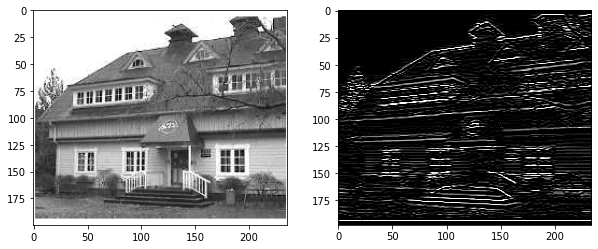

In [205]:
# zaladowane zdjecie
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(house_g, cmap='gray', vmin=0, vmax=255 ) 
ax2.imshow(convolution_v1(house_g, horizontal_lines_bw, 1),
           cmap='gray', vmin=0, vmax=255)
fig.set_size_inches(10,5)
plt.show()

#### Kolorowe zdjęcie
Jako że wyniki z każdego z trzech kanałów są sumowane, to postacią wyjściową po użyciu jednego trójkanałowego filtra jest jednokanałowy obraz.

Rozmiar filtra:  (3, 3, 3, 1)


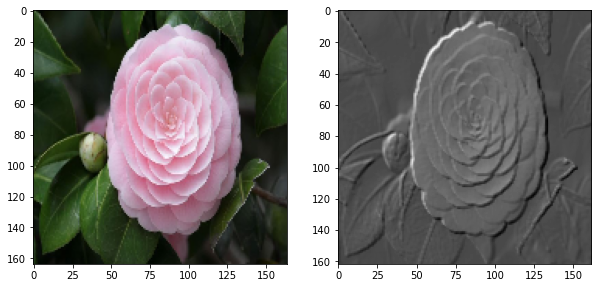

In [206]:
print("Rozmiar filtra: ", sharpen.shape)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(flower) 
ax2.imshow(convolution_v1(flower, emboss_filter), cmap='gray')
fig.set_size_inches(10,5)
plt.show()

Działanie parametru `stride`.

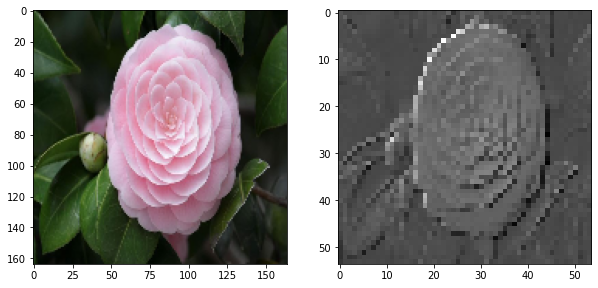

In [233]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(flower) 
ax2.imshow(convolution_v1(flower, emboss_filter, stride=3), cmap='gray')
fig.set_size_inches(10,5)
plt.show()

# Mnożenie macierzowe
Funkcja `convolution_v2` implementuje implementuje operację konwolucji obrazka za pomocą mnożenia macierzy. Czarno-biały obrazek jest przekształcany do postaci macierzy, gdzie każda kolumna odpowiada każdej lokalizacji okienka filtra i posiada tyle wierszy ile elementów posiada filtr (czyli rozmiar macierzy to `(liczba elementów w pojedynczym filtrze, liczba możliwych pozycji ramki filtra na obrazku)`). W przypadku kolorowych obrazków, każda taka macierz przypada na każdy kanał i zostają połączone jedna pod drugą, czyli dla obrazka o 3 kanałach liczba rzędów w takiej macierzy wynosi `3 * (liczba elementów w pojedynczym filtrze)`.

`kernel` z postaci `(wysokosc, szerokosc, kanal, numer filtra)` zostaje przeksztalcony do macierzy `(numer filtra, wysokosc * szerokosc * kanal)`.

Funkcja przyjmuje takie same parametry jak funkcja `conovlution_v1`.

In [234]:
def convolution_v2(input_img, kernel, stride=1):
    input_height, input_width, input_channels = input_img.shape

    kernel_size = kernel.shape[0]
    n_filters = kernel.shape[3]
    output_height = int((input_height - kernel_size) / stride + 1)
    output_width = int((input_width - kernel_size) / stride + 1)

    column_form = im2col(input_img, kernel_size, stride)
    kernels_as_rows = kernel.reshape((n_filters, -1))

    output_rows = kernels_as_rows @ column_form
    output = output_rows.reshape((output_height, output_width, n_filters))

    return output

# funkcja wypelniajaca wartosci kolumnowej postaci obrazka
def im2col(input_image, kernel_size, stride):
    matrixI, matrixJ, channel_mask = get_indices_matrices(input_image, kernel_size, stride)
    column_form = input_image[matrixI, matrixJ, channel_mask]
    return column_form


# funkcja mapujaca indeksy z obrazka na indeksy formy kolumnowej
def get_indices_matrices(input_img, kernel_size, stride):
    input_height, input_width, input_channels = input_img.shape

    output_height = int((input_height - kernel_size) / stride + 1)
    output_width = int((input_width - kernel_size) / stride + 1)

    # maska wyznaczajaca ktore rzedy naleza do ktorego kanalu
    channel_mask = np.repeat(np.arange(input_channels), kernel_size**2).reshape(-1, 1)

    # y_axis ma rozmiar rowny liczbie elementow w jednym kernelu
    y_axis = np.repeat(np.arange(kernel_size), kernel_size)
    # y_axis powtorzony na kazdy kanal
    y_axis = np.tile(y_axis, input_channels)
    # kazde przejscie wszerz obrazka zwieksza indeks i  o 1
    positions = np.repeat(np.arange(output_height), output_width) * stride
    matrixI = positions.reshape(1, -1) + y_axis.reshape(-1, 1)


    y_axis = np.tile(np.arange(kernel_size), kernel_size)
    y_axis = np.tile(y_axis, input_channels)
    positions = np.tile(np.arange(output_width), output_height) * stride
    matrixJ = positions.reshape(1, -1) + y_axis.reshape(-1, 1)

    return matrixI, matrixJ, channel_mask

#### Czarno-białe zdjęcia
Skorzyjstajmy jeszcze raz tego samego przykładu co wcześniej.

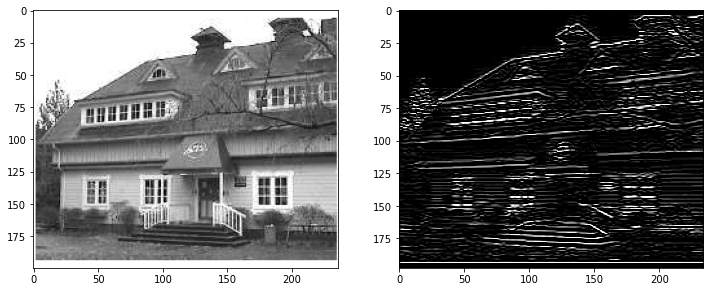

In [235]:
# zaladowane zdjecie
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(house_g, cmap='gray', vmin=0, vmax=255 ) 
ax2.imshow(convolution_v1(house_g, horizontal_lines_bw, 1),
           cmap='gray', vmin=0, vmax=255)
fig.set_size_inches(12,6)
plt.show()

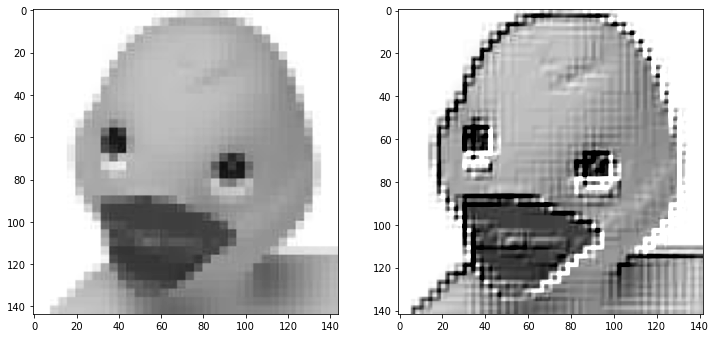

In [236]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(duck_g, cmap='gray', vmin=0, vmax=255 ) 
ax2.imshow(convolution_v2(duck_g, emboss_filter_bw, 1),
           cmap='gray', vmin=0, vmax=255)
fig.set_size_inches(12,6)
plt.show()

#### Kolorowe zdjęcia

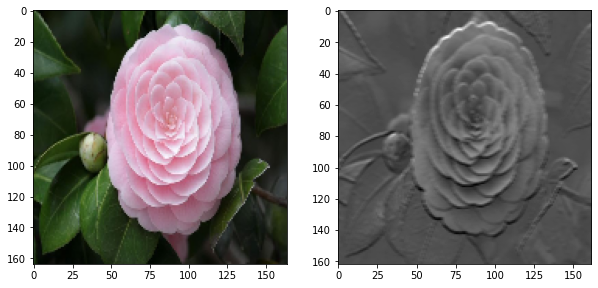

In [210]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(flower) 
ax2.imshow(convolution_v2(flower, emboss_filter), cmap='gray')
fig.set_size_inches(10,5)
plt.show()

Działa tu również parametr `stride`.

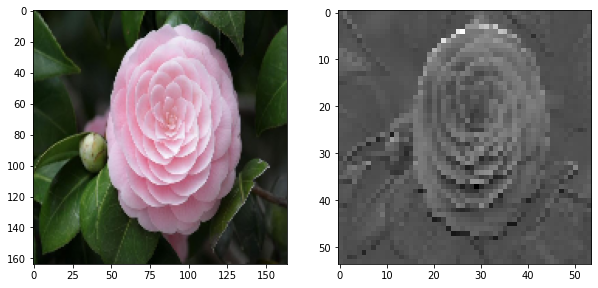

In [212]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(flower) 
ax2.imshow(convolution_v2(flower, emboss_filter, stride=3), cmap='gray')
fig.set_size_inches(10,5)
plt.show()

## Benchmark

Porównajmy teraz czas wykonywania się funkcji na zdjęciach o różnych rozmiarach.

In [230]:
# male zdjecie
flower.shape

(164, 164, 3)

In [231]:
%timeit -n1 convolution_v1(flower, emboss_filter, stride=1)

660 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [232]:
%timeit -n1 convolution_v2(flower, emboss_filter, stride=1)

11.8 ms ± 5.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [227]:
# duze zdjecie
big_img = imread('IMG_3334.jpg')
big_img.shape

(1200, 900, 3)

In [229]:
%timeit -n1 convolution_v1(big_img, emboss_filter, stride=1)

28.2 s ± 866 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [228]:
%timeit -n1 convolution_v2(big_img, emboss_filter, stride=1)

570 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Funkcja zaimplementowana za pomocą mnożenia macierzeowego jest prawie 60x szybsza. Różnice najbardziej się odczuwa przy większych zdjęciach. W implementacjach, które mają cel inny niż pokazowy, nie powinno się korzystać z pierwszego rozwiązania.